In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [305]:
import matplotlib.pyplot as plt
%matplotlib inline

In [303]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('muted')
sns.set_context(
    "notebook",
    font_scale=1,
    rc={"lines.linewidth": 2.5}
)

In [6]:
from models.evidential import Evidential

In [13]:
from tools.loss import *
import torch

In [326]:
logits = torch.randint(1, 10, size=(1, 2, 3, 3))
target = torch.randint(0, 2, size=(1, 1, 3, 3))
target = torch.stack((target, 1-target), dim=1)
target

tensor([[[[[0, 0, 1],
           [1, 0, 1],
           [0, 0, 0]]],


         [[[1, 1, 0],
           [0, 1, 0],
           [1, 1, 1]]]]])

In [358]:
x = []
y = []

for i in range(500):
    logits = torch.randint(1, 10, size=(1, 2, 300, 300))
    target = torch.randint(0, 2, size=(1, 300, 300))
    target = torch.stack((target, 1-target), dim=1)
    x.append(uce_loss(logits, target).mean())
    y.append(u_focal_loss(logits, target, n=0).mean())  

    if x[i] != y[i]:
        print("false")

Text(0.5, 1.0, 'UCE vs. UFocal')

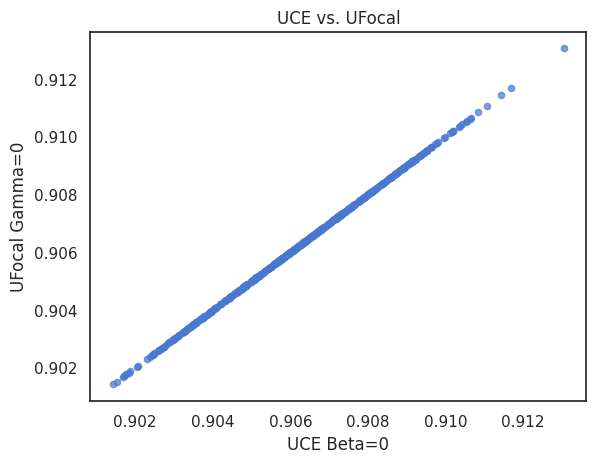

In [359]:
plt.scatter(x, y, alpha=.7, s=20)
plt.xlabel("UCE Beta=0")
plt.ylabel("UFocal Gamma=0")
plt.title("UCE vs. UFocal")

In [347]:
print(uce_loss(logits, target).mean())
print(u_focal_loss(logits, target, n=0).mean())

tensor(0.9890)
tensor(0.9890)


In [346]:
def uce_loss(alpha, y, weights=None):
    S = torch.sum(alpha, dim=1, keepdim=True)
    B = y * (torch.digamma(S) - torch.digamma(alpha) + 1e-10)

    if weights is not None:
        B *= weights.view(1, -1, 1, 1)

    A = torch.sum(B, dim=1, keepdim=True)

    return A


def u_focal_loss(alpha, y, weights=None, n=2):
    S = torch.sum(alpha, dim=1, keepdim=True)

    a0 = S
    aj = torch.gather(alpha, 1, torch.argmax(y, dim=1, keepdim=True))

    B = y * torch.exp((torch.lgamma(a0 - aj + n) + torch.lgamma(a0)) -
                      (torch.lgamma(a0 + n) + torch.lgamma(a0 - aj))) * (torch.digamma(a0 + n) - torch.digamma(aj))

    if weights is not None:
        B *= weights.view(1, -1, 1, 1)

    A = torch.sum(B, dim=1, keepdim=True)

    return A